<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Week 6: Clustering

**Clemson University**<br>
**Spring 2023**<br>
**Instructor(s):** Nina Hubig <br>
**Author(s):** Brandon Walker, Chris Kalahiki

---

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

%matplotlib inline 

<br>
<div class="exercise"><b>Question:</b> Why do we care about clustering? How/why is it useful?</div>
<p> <b>Answer:</b> Clustering is a powerful technique that helps to find patterns and groups in data without any prior knowledge about the data set. This can be useful in various fields such as customer segmentation and image processing. It can also help with things such as data visualization.  </p>
<br>

## Clustering Algorithms

We will now walk through three clustering algorithms, first discussing them at a high-level, then showing how to implement them with Python libraries. Let's first load and scale our data, so that particular dimensions don't naturally dominate in their contributions in the distant calculations:

In [3]:
# loads and displays our summary statistics of our data
multishapes = pd.read_csv("multishapes.csv")
multishapes.head()

,x,y,shape
0,-0.803739,-0.853053,1
1,0.852851,0.367618,1
2,0.927180,-0.274902,1
3,-0.752626,-0.511565,1
4,0.706846,0.810679,1


In [4]:
ms_df = multishapes[['x','y']]
ms_df.describe()

,x,y
count,1100.000000,1100.000000
mean,-0.081222,-0.625431
std,0.644967,1.176170
min,-1.489180,-3.353462
25%,-0.478839,-1.126752
50%,-0.132920,-0.297040
75%,0.366072,0.250817
max,1.492208,1.253874


In [5]:
# scales our data
scaled_df = pd.DataFrame(preprocessing.scale(ms_df), 
                         index=multishapes['shape'], 
                         columns=ms_df.columns)
scaled_df.describe()

,x,y
count,1.100000e+03,1100.000000
mean,4.521636e-17,0.000000
std,1.000455e+00,1.000455
min,-2.183985e+00,-2.320473
25%,-6.167723e-01,-0.426425
50%,-8.019252e-02,0.279331
75%,6.938298e-01,0.745340
max,2.440659e+00,1.598544


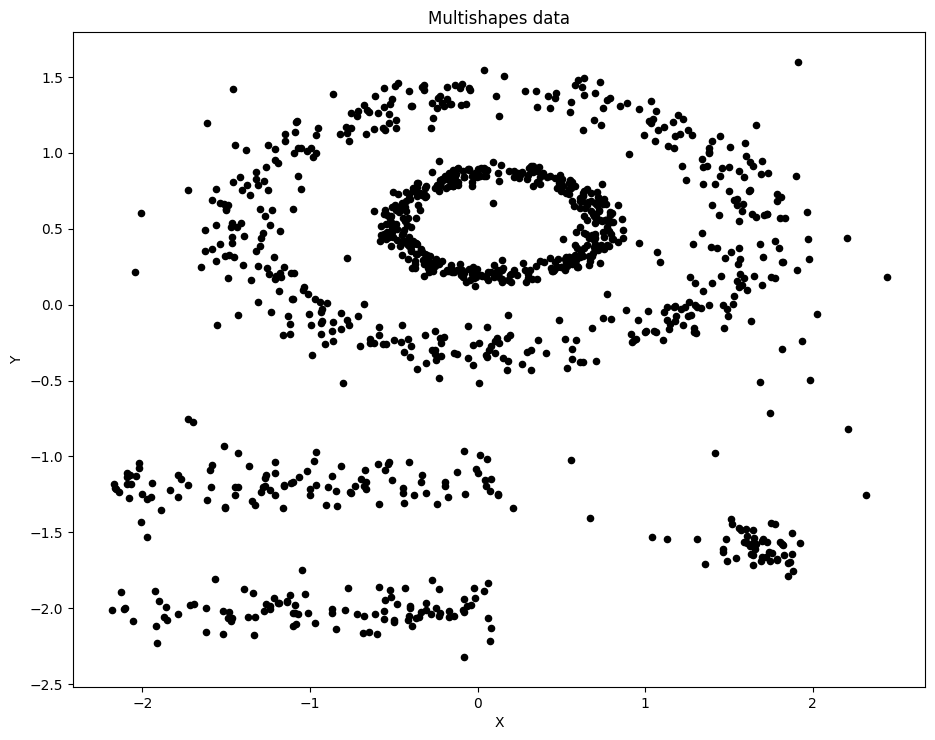

In [6]:
# plots our data
msplot = scaled_df.plot.scatter(x='x',y='y',c='Black',title="Multishapes data",figsize=(11,8.5))
msplot.set_xlabel("X")
msplot.set_ylabel("Y")
plt.show()

## k-Means clustering:

### Code (via `sklearn`):

In [7]:
from sklearn.cluster import KMeans

<div class="exercise"><b>Exercise #1</b>: </div>

For the first exercise:
- Create a KMeans object using 3 clusters and a random_state of 109.
- Fit the KMeans object to the scaled_df.

In [11]:
ms_kmeans = KMeans(n_clusters= 3, init='random', n_init= 3, random_state= 109).fit(scaled_df)

That's it! Just 1 line of code!

Now that we've run k-Means, we can look at various attributes of our clusters. Full documenation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [12]:
display(ms_kmeans.cluster_centers_)
display(ms_kmeans.labels_[0:10])

array([[ 1.06623356,  0.17403387],
       [-0.46343097,  0.54170897],
       [-0.98352608, -1.57663916]])

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1], dtype=int32)

### Plotting
Take note of matplotlib's `c=` argument to color items in the plot, along with our stacking two different plotting functions in the same plot.

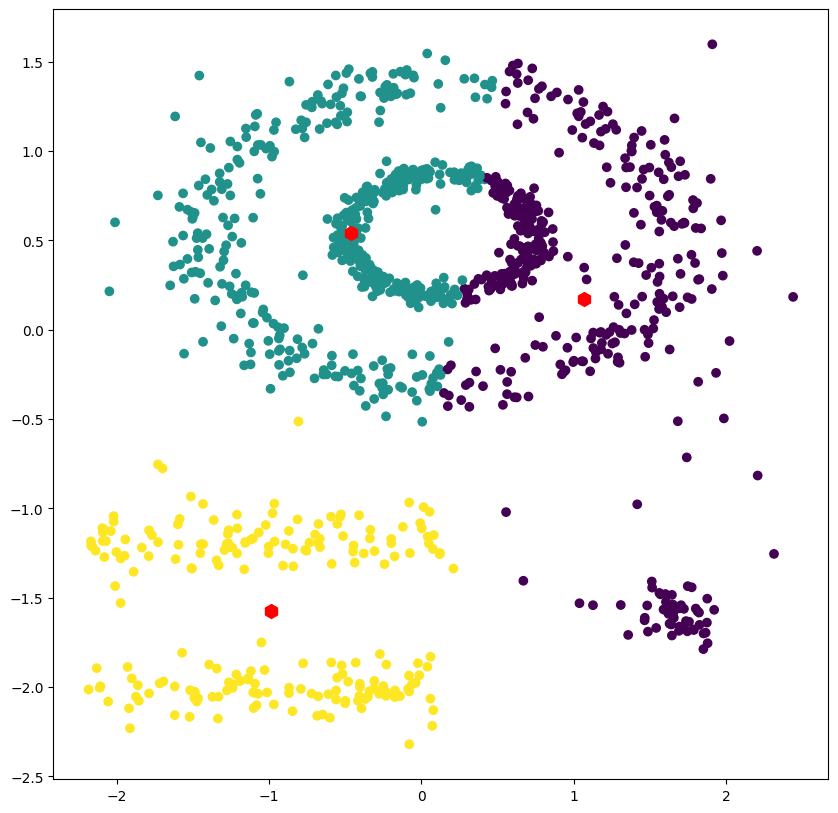

In [13]:
plt.figure(figsize=(10,10))

plt.scatter(scaled_df['x'], scaled_df['y'], c=ms_kmeans.labels_);
plt.scatter(ms_kmeans.cluster_centers_[:,0],
            ms_kmeans.cluster_centers_[:,1], 
            c='r', marker='h', s=100);

<div class="exercise"><b>Question</b>: Is this expected or did something go wrong? Should we always scale our data before clustering?</div>

<b>Answer:</b> This is expected and scaling is usually recommended because the algorithms can be sensitive to the scale of our features. Scaling can help ensure that all features contribute equally to the clustering process.

## Quality of Clusters: Inertia
Inertia measures the total squared distance from points to their cluster's centroid. We obviously want this distance to be relatively small. If we increase the number of clusters, it will naturally make the average distance smaller. If every point has its own cluster, then our distance would be 0. That's obviously not an ideal way to cluster. One way to determine a reasonable number of clusters to simply try many different clusterings as we vary **k**, and each time, measure the overall inertia.

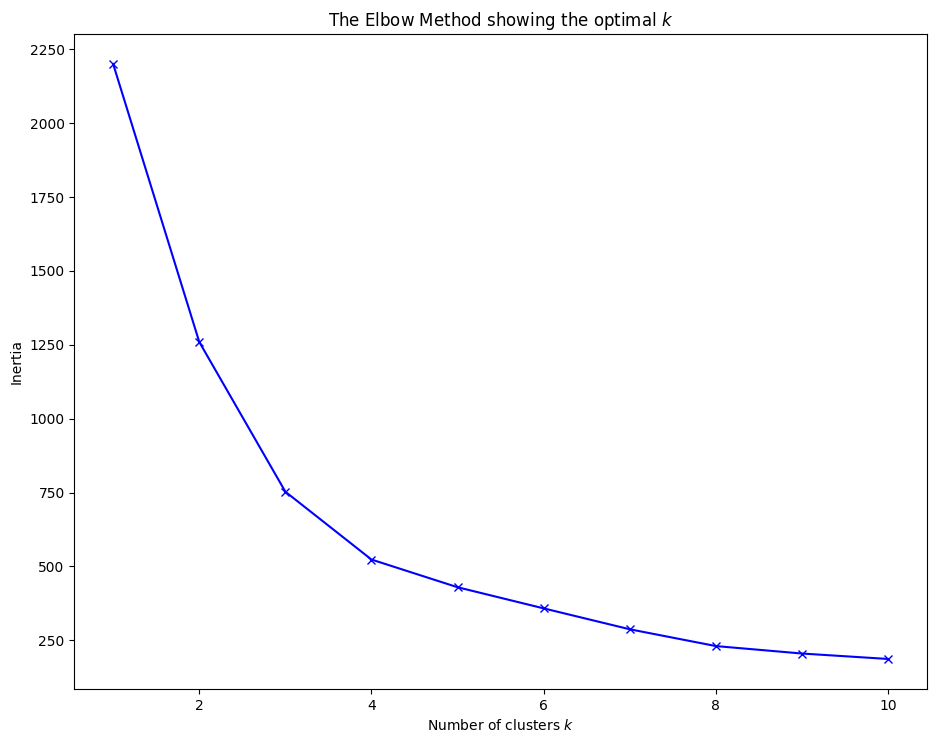

In [14]:
wss = []
for i in range(1,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

Look for the place(s) where distance stops decreasing as much (i.e., the 'elbow' of the curve). It seems that 4 would be a good number of clusters, as a higher *k* yields diminishing returns.

## Quality of Clusters: Silhouette

Let's say we have a data point $i$, and the cluster it belongs to is referred to as $C(i)$. One way to measure the quality of a cluster $C(i)$ is to measure how close its data points are to each other (within-cluster) compared to nearby, other clusters $C(j)$. This is what `Silhouette Scores` provide for us. The range is [-1,1]; 0 indicates a point on the decision boundary (equal average closeness to points intra-cluster and out-of-cluster), and negative values mean that datum might be better in a different cluster.

Specifically, let $a(i)$ denote the average distance data point $i$ is to the other points in the same cluster:

<center>
<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/silhouette_intra.png">
</center>

Similarly, we can also compute the average distance that data point $i$ is to all **other** clusters. The cluster that yields the minimum distance is denoted by $b(i)$:  

<center>
<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/silhouette_outer.png">
</center>

Hopefully our data point $i$ is much closer, on average, to points within its own cluster (i.e., $a(i)$ than it is to its closest neighboring cluster $b(i)$). The silhouette score quantifies this as $s(i)$:

<center>
<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/silhouette_eq.png">
</center>

**NOTE:** If data point $i$ belongs to its own cluster (no other points), then the silhouette score is set to 0 (otherwise, $a(i)$ would be undefined).

The silhouette score plotted below is the **overall average** across all points in our dataset.

The `silhouette_score()` function is available in `sklearn`. We can manually loop over values of K (for applying k-Means algorithm), then plot its silhouette score.

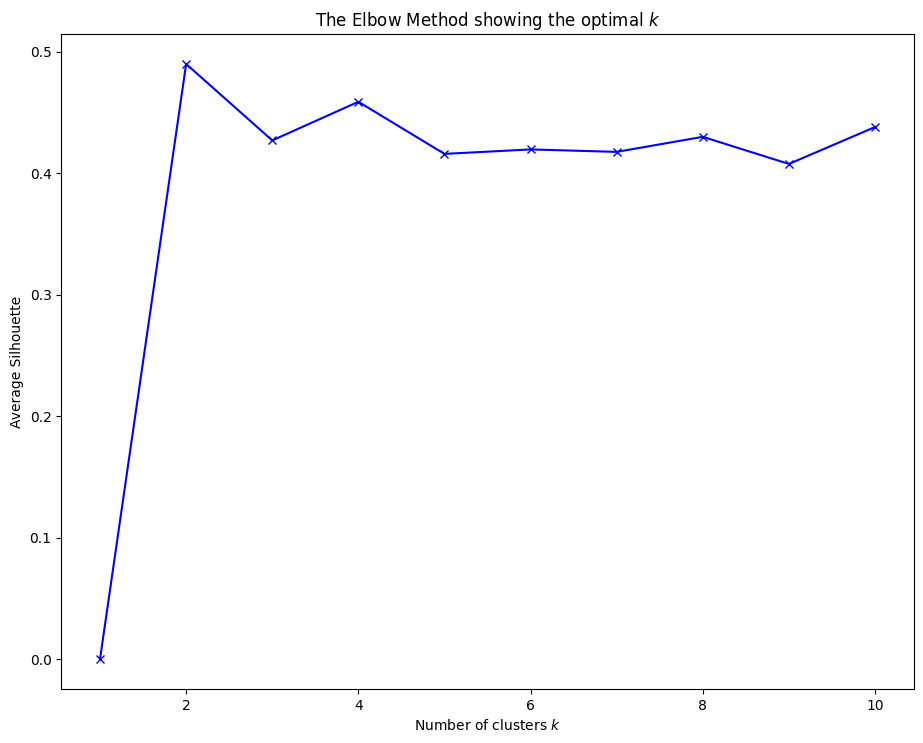

In [15]:
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    score = silhouette_score(scaled_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

### Visualizing all Silhoutte scores for a particular clustering

Below, we borrow from an `sklearn` example. The second plot may be overkill.
 - The second plot is just the scaled data.
 - If you only need the raw silhouette scores, use the `silhouette_samples()` function

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 3, the average silhouette_score is 0.4269854455072775.


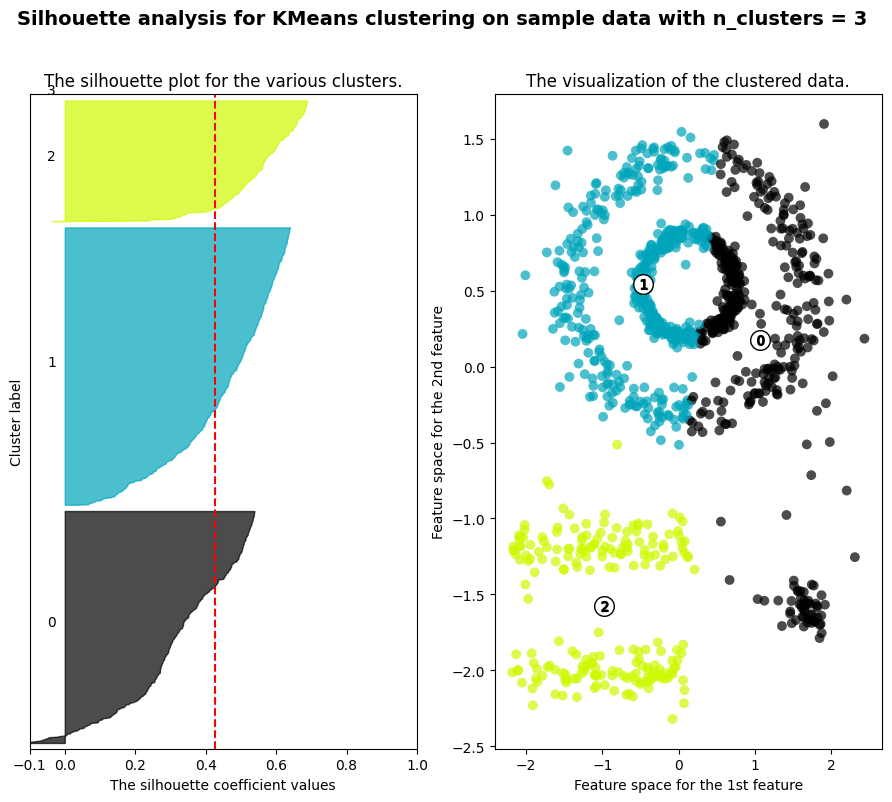

In [17]:
# run k-means with 3 clusters
ms_kmeans = KMeans(n_clusters=3, init='random', n_init=3, random_state=109).fit(scaled_df)

# plot a fancy silhouette plot
silplot(scaled_df.values, ms_kmeans)

## Quality of Clusters: Gap Statistic
The gap statistic compares within-cluster distances (like in silhouette), but instead of comparing against the second-best existing cluster for that point, it compares our clustering's overall average to the average we'd see if the data were generated at random (we'd expect randomly generated data to not necessarily have any inherit patterns that can be easily clustered).

In essence, the within-cluster distances (in the elbow plot) will go down just becuse we have more clusters. We additionally calculate how much they'd go down on non-clustered data with the same spread as our data and subtract that trend out to produce the plot below.

In [18]:
# If you need to install the gap_statistic package
# !pip install gap_stat

In [20]:
from gap_statistic import OptimalK

gs_obj = OptimalK()

n_clusters = gs_obj(scaled_df.values, n_refs=50, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  12


In [22]:
gs_obj.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,1.0,0.429158,78.255735,0.023554,1180.035538,1194.395240,0.060956,1197.751477
1,2.0,0.428230,121.803512,0.060028,676.780019,694.495958,-0.092129,682.855899
2,3.0,0.541617,27.192977,0.021258,541.331842,547.407721,0.201613,551.584735
3,4.0,0.410389,65.476423,0.070385,290.348945,300.601838,-0.027978,293.770468
4,5.0,0.467616,20.550283,0.029249,262.259319,265.680842,0.127940,265.285291
5,6.0,0.375602,20.887976,0.035926,184.425544,187.451515,-0.124591,187.272024
6,7.0,0.535486,17.764314,0.035293,209.904587,212.751067,0.275566,212.346758
7,8.0,0.298975,17.229429,0.039055,113.790113,116.232284,-0.083636,115.766435
8,9.0,0.416285,13.116966,0.033674,133.241787,135.218110,-0.150606,135.371753
9,10.0,0.605514,13.258623,0.038622,157.521644,159.651610,0.010951,159.578217


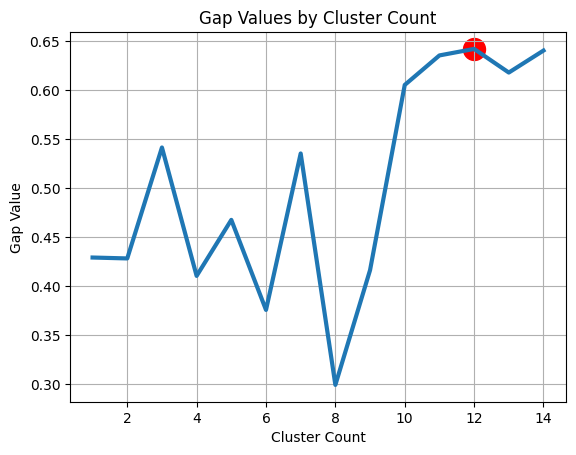

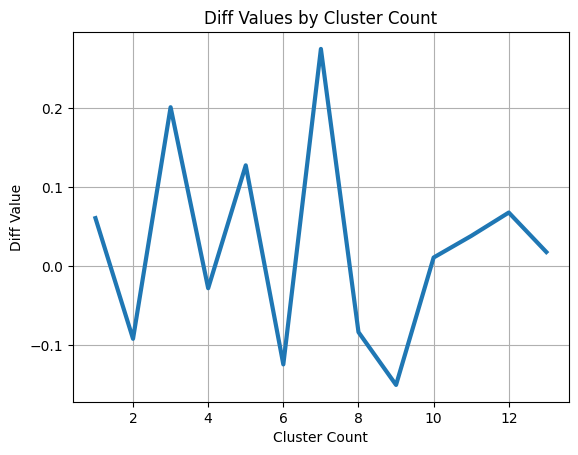

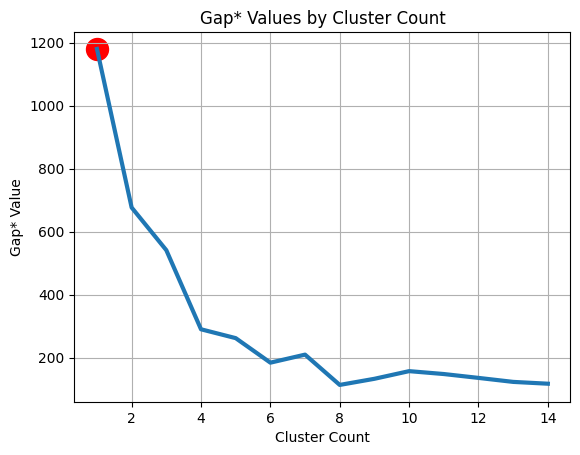

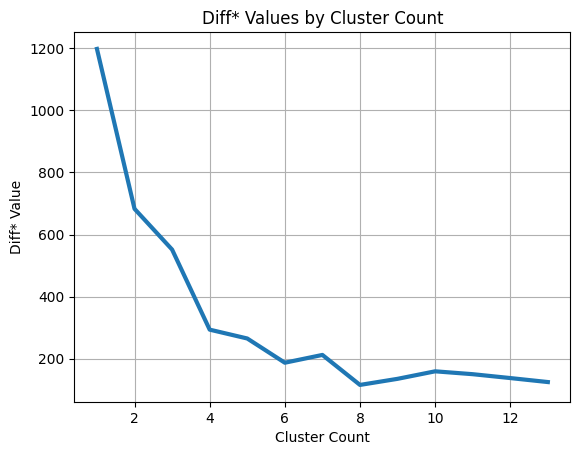

In [23]:
gs_obj.plot_results() # makes nice plots

If we wish to add error bars to help us decide how many clusters to use, the following code displays such:

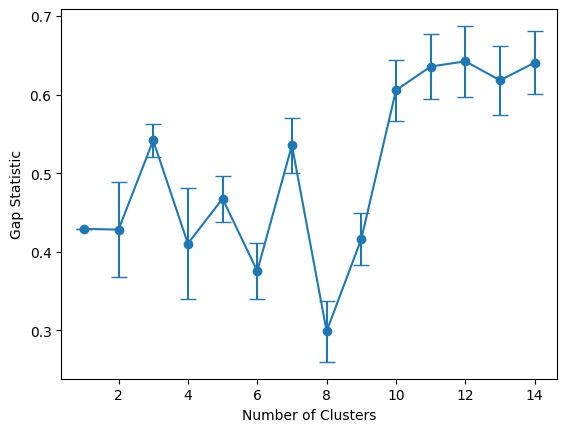

In [24]:
def display_gapstat_with_errbars(gap_df):
    gaps = gap_df["gap_value"].values
    diffs = gap_df["diff"]
    
    err_bars = np.zeros(len(gap_df))
    err_bars[1:] = diffs[:-1] - gaps[:-1] + gaps[1:]

    plt.scatter(gap_df["n_clusters"], gap_df["gap_value"])
    plt.errorbar(gap_df["n_clusters"], gap_df["gap_value"], yerr=err_bars, capsize=6)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Gap Statistic")
    plt.show()
    
display_gapstat_with_errbars(gs_obj.gap_df)

For more information about the `gap_stat` package, please see [the full documentation here](https://github.com/milesgranger/gap_statistic).

## Agglomerative Clustering

### Code (via `scipy`):

There are many different cluster-merging criteria, one of which is Ward's criteria. Ward's optimizes having the lowest total within-cluster distances, so it merges the two clusters that will harm this objective least.
`scipy`'s agglomerative clustering function implements Ward's method.

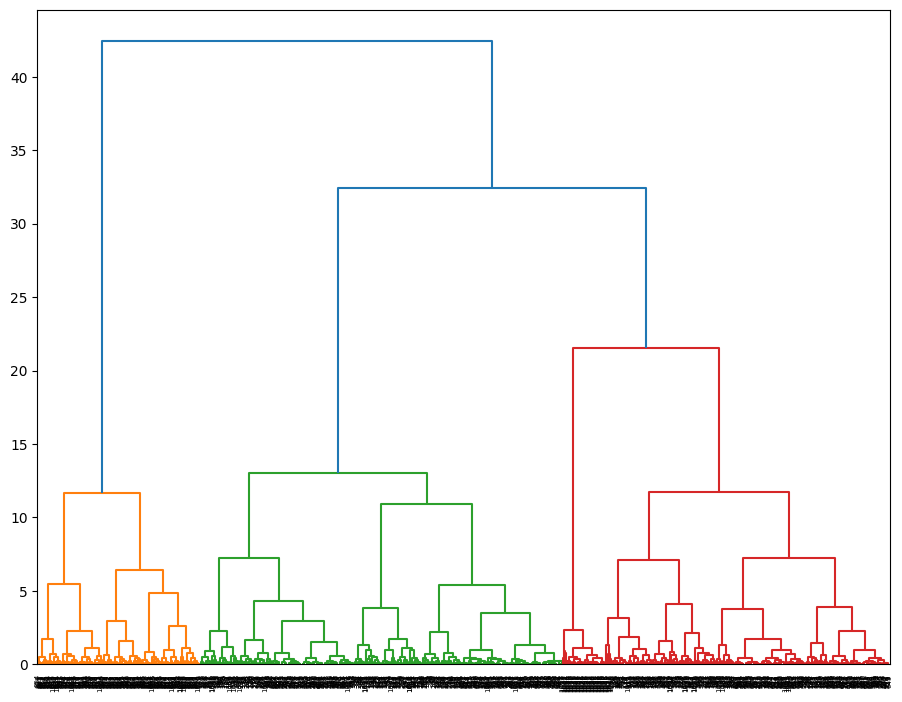

In [25]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data);

<br>
How do you read a plot like the above? What are valid options for number of clusters, and how can you tell? Are some more valid than others? Does it make sense to compute silhouette scores for an agglomerative clustering? If we wanted to compute silhouette scores, what would we need for this to be possible?</div>

### Lessons:
 - It's expensive: O(n^3) time complexity and O(n^2) space complexity.
 - Many choices for linkage criteria
 - Every node gets clustered (no child left behind)

## DBscan Clustering
DBscan uses an intuitive notion of denseness to define clusters, rather than defining clusters by a central point as in k-means.

### Code (via `sklearn`):
DBscan is implemented in good 'ol sklearn, but there aren't great automated tools for searching for the optimal `epsilon` parameter. For full documentation, please [visit this page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

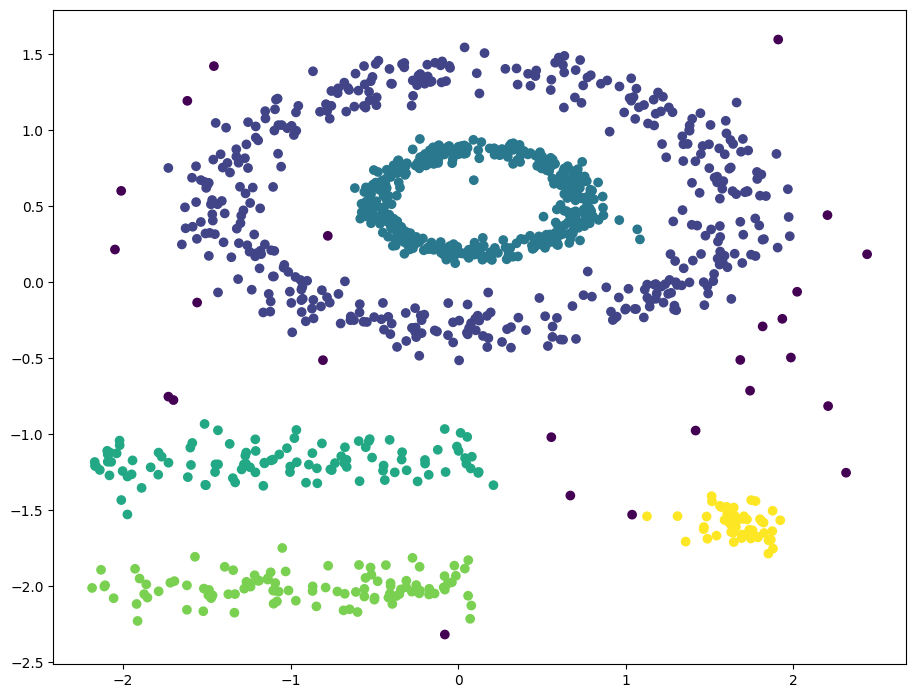

In [26]:
from sklearn.cluster import DBSCAN

plt.figure(figsize=(11,8.5))

fitted_dbscan = DBSCAN(eps=0.2).fit(scaled_df)

plt.scatter(scaled_df['x'], scaled_df['y'], c=fitted_dbscan.labels_);

**Note:** the dark purple dots are not clustered with anything else. They are lone singletons. You can validate such by setting epsilon to a very small value, and increase the min_samples to a high value. Under these conditions, nothing would cluster, and yet all dots become dark purple.

<br>

<div class="exercise"><b>Practice</b>: Experiment with the above code by changing its epsilon value and the min_samples (what is the default value for it, since the above code doesn't specify a value?)</div>

Instead of just empirically observing how the epsilon value affects the clustering (which would be very costly for large, high-dimensional data), we can also inspect how far each data point is to its $N^{th}$ closest neighbor:

In [28]:
from sklearn.neighbors import NearestNeighbors

# x-axis is each individual data point, numbered by an artificial index
# y-axis is the distance to its 2nd closest neighbor
def plot_epsilon(df, min_samples):
    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)

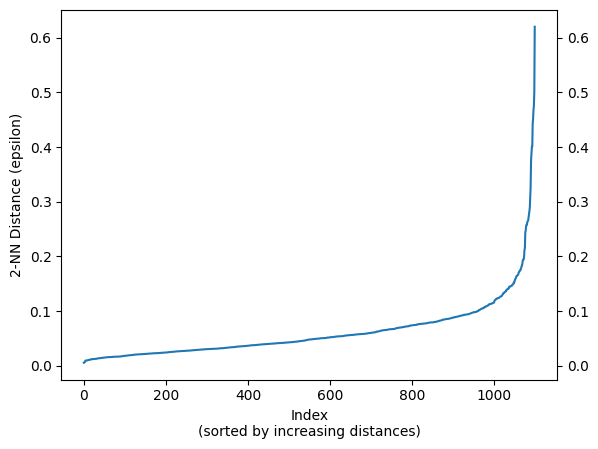

In [29]:
plot_epsilon(scaled_df, 3)

### Lessons:
 - Can cluster non-linear relationships very well; potential for more natural, arbritrarily shaped groupings
 - Does not require specifying the # of clusters (i.e., **k**); the algorithm determines such
 - Robust to outliers
 - Very sensitive to the parameters (requires strong knowledge of the data)
 - Doesn't guarantee that every (or ANY) item will be clustered